In [ ]:
import pandas as pd

# DATA SOURCE / CONFIDENTIALITY NOTE
# The original CSV files contain sensitive road incident records related to
# Advanced Driver Assistance Systems (ADAS) and Automated Driving Systems (ADS).
# For privacy and compliance reasons, these raw datasets are NOT included in this
# public repository, and the original local machine paths have been removed.
#
# To reproduce this analysis:
# 1. Prepare your own incident report datasets with a similar schema, e.g.:
#    - SGO-2021-01_Incident_Reports_ADAS.csv   (driver-assist system incidents)
#    - SGO-2021-01_Incident_Reports_ADS.csv    (automated / self-driving incidents)
#    - SGO-2021-01_Incident_Reports_OTHER.csv  (other vehicle tech / baseline incidents)
# 2. Store them locally (not committed to GitHub) under a folder called `data/`
# 3. Update or reuse the relative paths below.

# Relative paths to your private/local copies (these files are intentionally git-ignored)
adas_file_path = 'data/SGO-2021-01_Incident_Reports_ADAS.csv'
ads_file_path = 'data/SGO-2021-01_Incident_Reports_ADS.csv'
other_file_path = 'data/SGO-2021-01_Incident_Reports_OTHER.csv'


adas_data = pd.read_csv(adas_file_path, encoding='latin1')
ads_data = pd.read_csv(ads_file_path, encoding='latin1')
other_data = pd.read_csv(other_file_path, encoding='latin1')

# Display the first few rows of each dataframe to understand their structure
print(adas_data.head())
print(ads_data.head())
print(other_data.head())


Empty DataFrame
Columns: [ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America]
Index: []
    Report ID  Report Version               Reporting Entity Report Type  \
0  30270-6855               1                      Waymo LLC     Monthly   
1  30531-6864               1  Transdev Alternative Services     Monthly   
2  30531-6863               1  Transdev Alternative Services     Monthly   
3  30531-6862               1  Transdev Alternative Services     Monthly   
4  30270-6857               1                      Waymo LLC     Monthly   

   Report Month  Report Year Report Submission Date          VIN  \
0          11.0       2023.0               DEC-2023  SADHW2S1XM1   
1          11.0       2023.0               DEC-2023  SADHW2S1XM1   
2          11.0       2023.0               DEC-2023  SADHW2S19M1   
3          11.0       2023.0               DEC-2023  SADHW2S11M1   
4          11.0

In [6]:
# Data cleaning: dropping duplicates, handling missing values, etc.
adas_data.drop_duplicates(inplace=True)
ads_data.drop_duplicates(inplace=True)
other_data.drop_duplicates(inplace=True)

In [8]:
# Merge dataframes if necessary, for a combined analysis
combined_data = pd.concat([adas_data, ads_data, other_data], ignore_index=True)

In [10]:
# Identify and remove irrelevant columns
irrelevant_columns = ['VIN', 'City', 'Latitude', 'Longitude', 'Investigating Officer Name',
                      'Investigating Officer Phone', 'Investigating Officer Email', 
                      'ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America',
                      'Narrative', 'Narrative - CBI?']

In [12]:
# Remove only columns that exist in the dataframe
columns_to_drop = [col for col in irrelevant_columns if col in combined_data.columns]
combined_data.drop(columns=columns_to_drop, inplace=True)

In [14]:
# Handle missing values for numeric and non-numeric columns separately
numeric_columns = combined_data.select_dtypes(include=['number']).columns
non_numeric_columns = combined_data.select_dtypes(exclude=['number']).columns

In [16]:
combined_data[numeric_columns] = combined_data[numeric_columns].fillna(combined_data[numeric_columns].median())

In [18]:
# Fill missing values in non-numeric columns
combined_data[non_numeric_columns] = combined_data[non_numeric_columns].fillna(combined_data[non_numeric_columns].mode().iloc[0])

C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_24364\3508331431.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data[non_numeric_columns] = combined_data[non_numeric_columns].fillna(combined_data[non_numeric_columns].mode().iloc[0])


In [20]:
# Explicitly convert non-numeric columns to their inferred types to avoid the warning
combined_data[non_numeric_columns] = combined_data[non_numeric_columns].infer_objects(copy=False)


In [22]:
# Convert date columns to datetime, specifying the format if known
def parse_dates(df, date_column, date_formats):
    for fmt in date_formats:
        try:
            df[date_column] = pd.to_datetime(df[date_column], format=fmt, errors='raise')
            return df
        except (ValueError, TypeError):
            pass
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

In [24]:
date_formats = ['%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y']  # add other common formats as needed
combined_data = parse_dates(combined_data, 'Report Submission Date', date_formats)


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_24364\2681092772.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')


In [26]:
# Display the cleaned data structure
print(combined_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Columns: 129 entries, ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America to Within ODD? - CBI
dtypes: datetime64[ns](1), float64(8), object(120)
memory usage: 3.4+ MB
None


In [28]:
# Create new features using pd.concat to avoid fragmentation
new_features = pd.DataFrame({
    'Incident_Month': combined_data['Report Submission Date'].dt.month,
    'Incident_Year': combined_data['Report Submission Date'].dt.year
})

In [30]:
combined_data = pd.concat([combined_data, new_features], axis=1)

In [32]:
# Encode categorical variables
combined_data = pd.get_dummies(combined_data, columns=['Reporting Entity', 'State'], drop_first=True)


In [34]:
# Ensure all remaining columns are numeric
print(combined_data.dtypes)

ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America    float64
Report ID                                                                                                                                                  object
Report Version                                                                                                                                            float64
Report Type                                                                                                                                                object
Report Month                                                                                                                                              float64
                                                                                                                                                           ...   
State_TX                    

In [36]:
# Verify there are no non-numeric columns
print("Non-numeric columns:")
print(combined_data.select_dtypes(exclude=['number']).columns)

Non-numeric columns:
Index(['Report ID', 'Report Type', 'Report Submission Date', 'VIN - Unknown',
       'Serial Number', 'Make', 'Model', 'Model - Unknown',
       'Model Year - Unknown', 'Same Vehicle ID',
       ...
       'State_NM ', 'State_NV ', 'State_OH ', 'State_PA ', 'State_RI ',
       'State_TX ', 'State_UNK', 'State_VA ', 'State_WA ', 'State_WY '],
      dtype='object', length=250)


In [38]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# Define features and target variable
features = combined_data.drop(columns=['Highest Injury Severity Alleged'])
target = combined_data['Highest Injury Severity Alleged']

In [40]:
# Check if there are any remaining non-numeric columns in features
non_numeric_features = features.select_dtypes(exclude=['number']).columns
if len(non_numeric_features) > 0:
    print(f"Non-numeric columns found: {non_numeric_features}")
    features = features.drop(columns=non_numeric_features)

Non-numeric columns found: Index(['Report ID', 'Report Type', 'Report Submission Date', 'VIN - Unknown',
       'Serial Number', 'Make', 'Model', 'Model - Unknown',
       'Model Year - Unknown', 'Same Vehicle ID',
       ...
       'State_NM ', 'State_NV ', 'State_OH ', 'State_PA ', 'State_RI ',
       'State_TX ', 'State_UNK', 'State_VA ', 'State_WA ', 'State_WY '],
      dtype='object', length=249)


In [44]:
# Verify there are no non-numeric columns in features after dropping
print("Non-numeric columns after dropping:")
print(features.select_dtypes(exclude=['number']).columns)

Non-numeric columns after dropping:
Index([], dtype='object')


In [46]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [48]:
# Train a Random Forest Classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [52]:
rf_model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=4)  # Adjust number of splits to a value <= least populated class

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

Fitting 4 folds for each of 216 candidates, totalling 864 fits


In [53]:
# Make predictions
y_pred = best_rf_model.predict(X_test)

In [54]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
[[  9   0  18   0   0]
 [  0   2   0   0   0]
 [  0   0 631   2   2]
 [  0   0   0   0   0]
 [  0   0   6   0  13]]

Classification Report:
                      precision    recall  f1-score   support

               Minor       1.00      0.33      0.50        27
            Moderate       1.00      1.00      1.00         2
No Injuries Reported       0.96      0.99      0.98       635
             Serious       0.00      0.00      0.00         0
             Unknown       0.87      0.68      0.76        19

            accuracy                           0.96       683
           macro avg       0.77      0.60      0.65       683
        weighted avg       0.96      0.96      0.95       683



In [55]:
# Additional metrics with zero_division parameter
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

In [56]:
print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.95900439238653
Precision: 0.962224730738137
Recall: 0.95900439238653
F1 Score: 0.953508735034073


In [57]:
# Cross-validation scores
cv_scores = cross_val_score(best_rf_model, features, target, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation scores: [0.28571429 0.94021102 0.94724502 0.94607268]
Mean cross-validation score: 0.7798107519678446


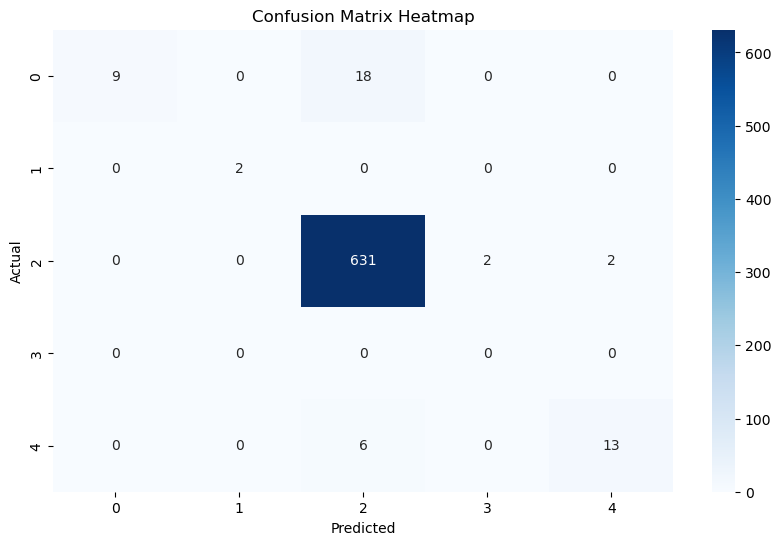

In [58]:
# Visualizations
# Confusion matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Length of feature_names: 10
Length of importances: 10


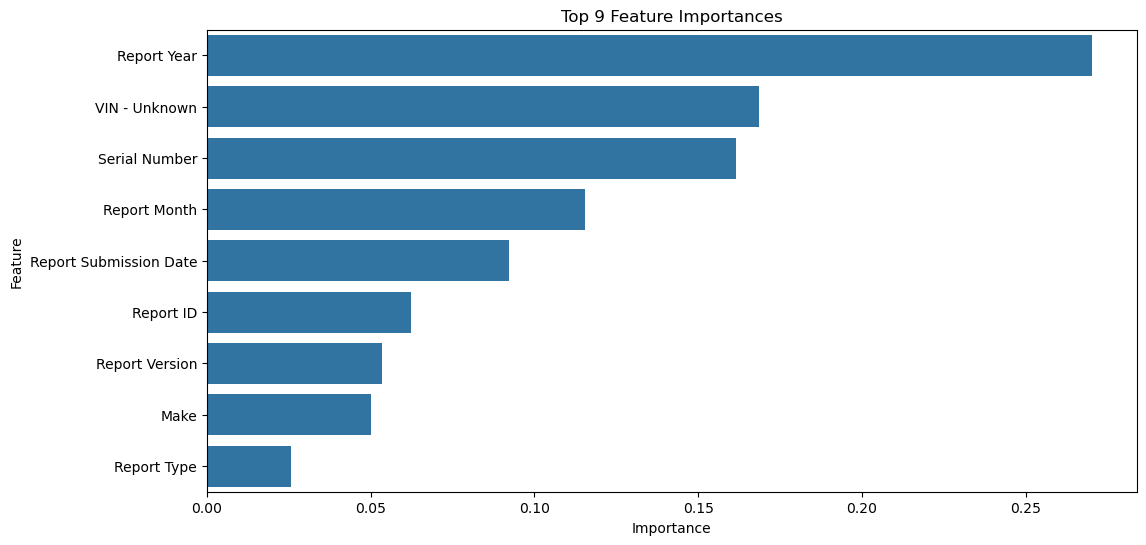

In [78]:
# Remove the specific feature if it exists in the feature names
feature_to_remove = 'ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America'
if feature_to_remove in feature_names:
    feature_names = feature_names.drop(feature_names.index(feature_to_remove))

# Debugging the mismatch
print(f"Length of feature_names: {len(feature_names)}")
print(f"Length of importances: {len(importances)}")

# If there's a mismatch, identify where it comes from
if len(importances) > len(feature_names):
    print("Error: There are more importances than feature names. Check the model or preprocessing steps.")
elif len(importances) < len(feature_names):
    missing_features = set(feature_names) - set(importances)
    print("These features are in 'feature_names' but not in 'importances':", missing_features)
    
    # If needed, truncate feature_names to match the length of importances
    feature_names = feature_names[:len(importances)]

    # Proceed with creating the DataFrame
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the top 9 feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importances.head(9), x='Importance', y='Feature')
    plt.title('Top 9 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
else:
    # If lengths match, directly create the DataFrame and plot
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot the top 9 feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importances.head(9), x='Importance', y='Feature')
    plt.title('Top 9 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


In [82]:
# Replace with actual ADAS-related features from your dataset
adas_features = ['Feature1', 'Feature2', 'Feature3']  # example features

In [84]:
# Ensure these features exist in the dataset
adas_features = [feature for feature in adas_features if feature in combined_data.columns]


In [86]:
# Fit a logistic regression model to evaluate the impact of ADAS on incident severity
X = combined_data[adas_features]
y = combined_data['Highest Injury Severity Alleged'].apply(lambda x: 1 if x in ['Serious', 'Fatality'] else 0)


In [88]:
logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.041867
         Iterations 9


In [90]:
print(result.summary())

                                  Logit Regression Results                                 
Dep. Variable:     Highest Injury Severity Alleged   No. Observations:                 3413
Model:                                       Logit   Df Residuals:                     3412
Method:                                        MLE   Df Model:                            0
Date:                             Fri, 30 Aug 2024   Pseudo R-squ.:               1.556e-11
Time:                                     15:16:14   Log-Likelihood:                -142.89
converged:                                    True   LL-Null:                       -142.89
Covariance Type:                         nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9502      0.205    -24.166      0.000      -5.352      -4.549


C:\Users\Joseph Okpono\AppData\Local\Temp\ipykernel_31424\3690622777.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')


ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America    float64
Report ID                                                                                                                                                  object
Report Version                                                                                                                                            float64
Reporting Entity                                                                                                                                           object
Report Type                                                                                                                                                object
                                                                                                                                                           ...   
Inv. Officer Name - Unknown 

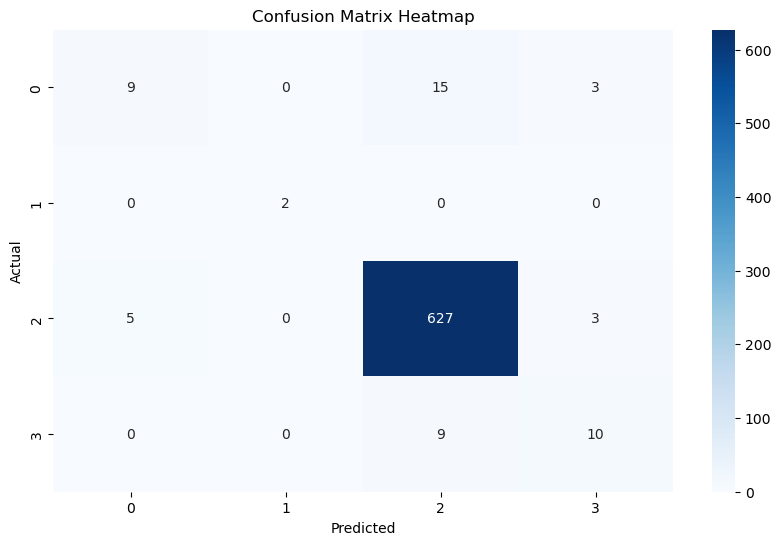

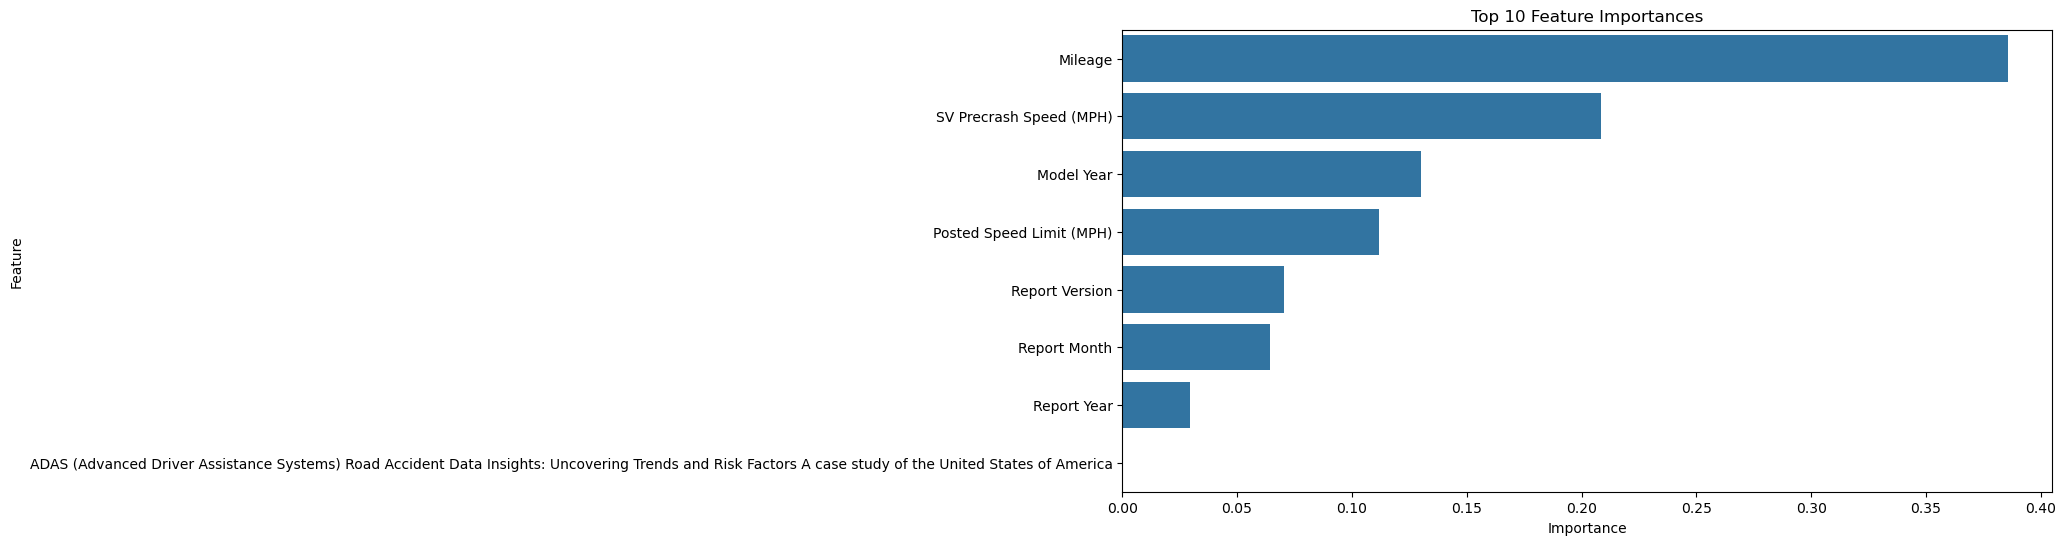

No ADAS-related features found in the dataset.


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the data
adas_file_path = 'C:/Users/Joseph Okpono/Desktop/Joseph and Stewart Technical paper on Data Analysis/SGO-2021-01_Incident_Reports_ADAS.csv'
ads_file_path = 'C:/Users/Joseph Okpono/Desktop/Joseph and Stewart Technical paper on Data Analysis/SGO-2021-01_Incident_Reports_ADS.csv'
other_file_path = 'C:/Users/Joseph Okpono/Desktop/Joseph and Stewart Technical paper on Data Analysis/SGO-2021-01_Incident_Reports_OTHER.csv'

adas_data = pd.read_csv(adas_file_path, encoding='latin1')
ads_data = pd.read_csv(ads_file_path, encoding='latin1')
other_data = pd.read_csv(other_file_path, encoding='latin1')

# Merge dataframes if necessary
combined_data = pd.concat([adas_data, ads_data, other_data], ignore_index=True)

# Identify and remove irrelevant columns
irrelevant_columns = ['VIN', 'City', 'Latitude', 'Longitude', 'Investigating Officer Name',
                      'Investigating Officer Phone', 'Investigating Officer Email', 
                      'ADAS (Advanced Driver Assistance Systems) Road Accident Data Insights: Uncovering Trends and Risk Factors A case study of the United States of America',
                      'Narrative', 'Narrative - CBI?']

columns_to_drop = [col for col in irrelevant_columns if col in combined_data.columns]
combined_data.drop(columns=columns_to_drop, inplace=True)

# Handle missing values
numeric_columns = combined_data.select_dtypes(include=['number']).columns
non_numeric_columns = combined_data.select_dtypes(exclude=['number']).columns

# Fill missing values
combined_data[numeric_columns] = combined_data[numeric_columns].fillna(combined_data[numeric_columns].median())
combined_data[non_numeric_columns] = combined_data[non_numeric_columns].fillna(combined_data[non_numeric_columns].mode().iloc[0])
combined_data[non_numeric_columns] = combined_data[non_numeric_columns].infer_objects(copy=False)

# Function to parse dates with known formats first, then fall back to dateutil
def parse_dates(df, date_column, date_formats):
    # Try each date format
    for fmt in date_formats:
        try:
            # Attempt to parse using the current format
            df[date_column] = pd.to_datetime(df[date_column], format=fmt, errors='raise')
            return df
        except (ValueError, TypeError):
            pass
    # Fallback to individual parsing using dateutil if none of the formats worked
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

# Example usage of the parse_dates function
date_formats = ['%Y-%m-%d', '%m/%d/%Y', '%d-%m-%Y', '%b %d, %Y']  # Add other common formats as needed
combined_data = parse_dates(combined_data, 'Report Submission Date', date_formats)

# Ensure all remaining columns are numeric
print(combined_data.dtypes)

# Define features and target variable
features = combined_data.drop(columns=['Highest Injury Severity Alleged'])
target = combined_data['Highest Injury Severity Alleged']

# Check if there are any remaining non-numeric columns in features
non_numeric_features = features.select_dtypes(exclude=['number']).columns
if len(non_numeric_features) > 0:
    print(f"Non-numeric columns found: {non_numeric_features}")
    features = features.drop(columns=non_numeric_features)

# Verify there are no non-numeric columns in features after dropping
print("Non-numeric columns after dropping:")
print(features.select_dtypes(exclude=['number']).columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a Random Forest Classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=4)  # Adjust number of splits to a value <= least populated class

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Additional metrics with zero_division parameter
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Cross-validation scores
cv_scores = cross_val_score(best_rf_model, features, target, cv=cv)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Visualizations
# Confusion matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = best_rf_model.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Logistic regression for ADAS impact
adas_features = [feature for feature in ['Feature1', 'Feature2', 'Feature3'] if feature in combined_data.columns]  # Replace with actual ADAS-related features from your dataset

if adas_features:
    X = combined_data[adas_features]
    y = combined_data['Highest Injury Severity Alleged'].apply(lambda x: 1 if x in ['Serious', 'Fatality'] else 0)

    logit_model = sm.Logit(y, sm.add_constant(X))
    result = logit_model.fit()
    print(result.summary())
else:
    print("No ADAS-related features found in the dataset.")
